In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import csv

In [2]:
transaction = pd.read_csv("transactions.csv", delimiter="|")
items = pd.read_csv("items.csv", delimiter="|")

In [3]:
transaction.head()

,sessionID,itemID,click,basket,order
0,0,21310,1,0,0
1,1,73018,1,0,0
2,2,19194,1,0,0
3,3,40250,1,0,0
4,4,46107,1,0,0


In [4]:
print(transaction.shape)
print(items.shape)

(365143, 5)
(78030, 6)


In [5]:
data = pd.merge(transaction, items, on=["itemID"])

In [6]:
data.shape

(365143, 10)

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 365143 entries, 0 to 365142
Data columns (total 10 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   sessionID   365143 non-null  int64 
 1   itemID      365143 non-null  int64 
 2   click       365143 non-null  int64 
 3   basket      365143 non-null  int64 
 4   order       365143 non-null  int64 
 5   title       365143 non-null  object
 6   author      323809 non-null  object
 7   publisher   365142 non-null  object
 8   main topic  364248 non-null  object
 9   subtopics   365143 non-null  object
dtypes: int64(5), object(5)
memory usage: 30.6+ MB


In [8]:
# choosing Target variable
#print(inner_merged_total['basket'].value_counts())
#print(inner_merged_total['click'].value_counts())
print(data['order'].value_counts())

0     348237
1      16593
2        255
3         18
4          7
5          7
21         4
10         2
25         2
7          2
27         2
12         2
11         2
6          1
28         1
14         1
15         1
19         1
20         1
22         1
23         1
26         1
13         1
Name: order, dtype: int64


In [9]:
##data preprocessing 
##generate target variable interest
data["Interest"] = data["click"] + data["basket"]+ data["order"]

## dropping season ID input for dr raheem
del data["sessionID"]

## aggregrate (idea is to generate the frequencies of item id, and multiply it by interest, getting the total interest of the items)

In [10]:
data.head()
#print(inner_merged_total['Interest'].value_counts())

,itemID,click,basket,order,title,author,publisher,main topic,subtopics,Interest
0,21310,1,0,0,Princess Poppy: The Big Mix Up,Janey Louise Jones,Penguin Random House Children's UK,YFB,[5AH],1
1,21310,1,0,0,Princess Poppy: The Big Mix Up,Janey Louise Jones,Penguin Random House Children's UK,YFB,[5AH],1
2,21310,1,0,0,Princess Poppy: The Big Mix Up,Janey Louise Jones,Penguin Random House Children's UK,YFB,[5AH],1
3,73018,1,0,0,Einfach zeichnen! Step by Step,Wiebke Krabbe,Schwager und Steinlein,AGZ,"[5AJ,AGZ,WFA,YBG,YBL,YNA,YPA]",1
4,73018,1,0,0,Einfach zeichnen! Step by Step,Wiebke Krabbe,Schwager und Steinlein,AGZ,"[5AJ,AGZ,WFA,YBG,YBL,YNA,YPA]",1


## Group by item ID, and then count the item ID, and then interest * count of itemID = total interest column

In [11]:
##generate frequency
test = data.value_counts(['itemID']).reset_index(name='Frequency')
print(test.head())

   itemID  Frequency
0   58522       2291
1   66247       1775
2   10666       1749
3   44220       1687
4   69185       1290


In [12]:
#Merging frequency 
book_data = pd.merge(data, test, on=["itemID"])
book_data.head()

,itemID,click,basket,order,title,author,publisher,main topic,subtopics,Interest,Frequency
0,21310,1,0,0,Princess Poppy: The Big Mix Up,Janey Louise Jones,Penguin Random House Children's UK,YFB,[5AH],1,3
1,21310,1,0,0,Princess Poppy: The Big Mix Up,Janey Louise Jones,Penguin Random House Children's UK,YFB,[5AH],1,3
2,21310,1,0,0,Princess Poppy: The Big Mix Up,Janey Louise Jones,Penguin Random House Children's UK,YFB,[5AH],1,3
3,73018,1,0,0,Einfach zeichnen! Step by Step,Wiebke Krabbe,Schwager und Steinlein,AGZ,"[5AJ,AGZ,WFA,YBG,YBL,YNA,YPA]",1,59
4,73018,1,0,0,Einfach zeichnen! Step by Step,Wiebke Krabbe,Schwager und Steinlein,AGZ,"[5AJ,AGZ,WFA,YBG,YBL,YNA,YPA]",1,59


In [13]:
#remove dupicate rows 
print(book_data.shape)
book_data.drop_duplicates(subset ="itemID", keep='first' ,inplace=True)
print(book_data.shape)

(365143, 11)
(24909, 11)


In [14]:
book_data.head()

,itemID,click,basket,order,title,author,publisher,main topic,subtopics,Interest,Frequency
0,21310,1,0,0,Princess Poppy: The Big Mix Up,Janey Louise Jones,Penguin Random House Children's UK,YFB,[5AH],1,3
3,73018,1,0,0,Einfach zeichnen! Step by Step,Wiebke Krabbe,Schwager und Steinlein,AGZ,"[5AJ,AGZ,WFA,YBG,YBL,YNA,YPA]",1,59
62,19194,1,0,0,Red Queen 1,Victoria Aveyard,Orion Publishing Group,YFH,"[5AP,FBA]",1,186
248,40250,1,0,0,Meine Kindergarten-Freunde (Pirat),NaN,Ars Edition GmbH,YB,"[5AC,5AD,YBG,YBL,YF]",1,339
587,46107,1,0,0,Mein großes Schablonen-Buch - Wilde Tiere,Elizabeth Golding,Edition Michael Fischer,WFTM,"[WD,WFTM,YBG,YBL,YBLD,YBLN1]",1,25


In [15]:
##compute total interest (interest*frequency)

In [16]:
##Generate total interest

book_data["Total_Interest"] = book_data["Frequency"] * book_data["Interest"] 

##Print latest book_data

book_data 


,itemID,click,basket,order,title,author,publisher,main topic,subtopics,Interest,Frequency,Total_Interest
0,21310,1,0,0,Princess Poppy: The Big Mix Up,Janey Louise Jones,Penguin Random House Children's UK,YFB,[5AH],1,3,3
3,73018,1,0,0,Einfach zeichnen! Step by Step,Wiebke Krabbe,Schwager und Steinlein,AGZ,"[5AJ,AGZ,WFA,YBG,YBL,YNA,YPA]",1,59,59
62,19194,1,0,0,Red Queen 1,Victoria Aveyard,Orion Publishing Group,YFH,"[5AP,FBA]",1,186,186
248,40250,1,0,0,Meine Kindergarten-Freunde (Pirat),NaN,Ars Edition GmbH,YB,"[5AC,5AD,YBG,YBL,YF]",1,339,339
587,46107,1,0,0,Mein großes Schablonen-Buch - Wilde Tiere,Elizabeth Golding,Edition Michael Fischer,WFTM,"[WD,WFTM,YBG,YBL,YBLD,YBLN1]",1,25,25
...,...,...,...,...,...,...,...,...,...,...,...,...
365138,21264,1,0,0,Soon,Morris Gleitzman,Penguin Random House Children's UK,YFN,[5AL],1,1,1
365139,22297,1,0,0,Warum? Fragen u. Antworten f. Kleinkinder - In...,NaN,Yo Yo Books,YBC,[YBL],1,1,1
365140,56041,1,0,0,Tesla,Mark Lingane,Insync Holdings Pty Ltd,FLM,[],1,1,1
365141,67832,2,0,0,Hexenherz. Glühender Hass,Monika Loerchner,Acabus Verlag,FMH,"[1D,FMH,FMR]",2,1,2


In [17]:
##Count total number for frequency and Total Interest
print(book_data['Total_Interest'].value_counts())


1       6781
2       3569
3       2006
4       1614
6       1053
        ... 
1687       1
983        1
727        1
599        1
3870       1
Name: Total_Interest, Length: 456, dtype: int64


In [18]:
#Latest Data types
book_data.dtypes



itemID             int64
click              int64
basket             int64
order              int64
title             object
author            object
publisher         object
main topic        object
subtopics         object
Interest           int64
Frequency          int64
Total_Interest     int64
dtype: object

In [19]:
##EDA for Click basket and order (any order without click find out), Make a pair plot using seaborn

In [20]:
##Create new column where order != 0 but basket and/or click is 0

def identify(book_data):

    if (book_data['order'] != 0 and (book_data['basket'] == 0) and (book_data['click'] == 0)):
        return 'Found'
    else:
        return 'Not found'

book_data['test'] = book_data.apply(identify, axis = 1)

book_data.head(10)

,itemID,click,basket,order,title,author,publisher,main topic,subtopics,Interest,Frequency,Total_Interest,test
0,21310,1,0,0,Princess Poppy: The Big Mix Up,Janey Louise Jones,Penguin Random House Children's UK,YFB,[5AH],1,3,3,Not found
3,73018,1,0,0,Einfach zeichnen! Step by Step,Wiebke Krabbe,Schwager und Steinlein,AGZ,"[5AJ,AGZ,WFA,YBG,YBL,YNA,YPA]",1,59,59,Not found
62,19194,1,0,0,Red Queen 1,Victoria Aveyard,Orion Publishing Group,YFH,"[5AP,FBA]",1,186,186,Not found
248,40250,1,0,0,Meine Kindergarten-Freunde (Pirat),NaN,Ars Edition GmbH,YB,"[5AC,5AD,YBG,YBL,YF]",1,339,339,Not found
587,46107,1,0,0,Mein großes Schablonen-Buch - Wilde Tiere,Elizabeth Golding,Edition Michael Fischer,WFTM,"[WD,WFTM,YBG,YBL,YBLD,YBLN1]",1,25,25,Not found
612,34217,1,0,0,Ewig geliebt,J. R. Ward,Heyne Taschenbuch,FMR,"[1KBB-US-NAK,FMX,FRX,3MRBF]",1,93,93,Not found
705,31436,1,0,0,Meine Sticker-Tiere,NaN,Ars Edition GmbH,YBG,"[5AD,YBG,YBLL]",1,28,28,Not found
733,14576,1,1,0,Unsterblich 01 - Tor der Dämmerung,Julie Kagawa,Heyne Taschenbuch,YFE,"[5AQ,FM,YFE,YFH]",2,31,62,Not found
764,17731,2,1,0,Unsterblich 02 - Tor der Nacht,Julie Kagawa,Heyne Taschenbuch,YFH,"[5AQ,FM,YFE,YFH]",3,18,54,Not found
782,58723,1,0,0,Pedro und die Bettler von Cartagena,Ursula Hasler,dtv Verlagsgesellschaft,YFB,"[5AM,1KLSC]",1,12,12,Not found


In [21]:
#Print how many counts for order column

print(book_data['order'].value_counts())


0    23968
1      925
2       15
5        1
Name: order, dtype: int64


In [22]:
## Print how many counts for test column

print(book_data['test'].value_counts())


Not found    24133
Found          776
Name: test, dtype: int64


In [23]:
## Print column where test == found

test_column = book_data.loc[book_data['test'] == 'Found']

test_column


,itemID,click,basket,order,title,author,publisher,main topic,subtopics,Interest,Frequency,Total_Interest,test
1850,73865,0,0,1,Wir spielen Kasperltheater,Peter Mitschitczek,Perlen-Reihe,ATDH,"[5AC,WDM,YBL,YND]",1,2,2,Found
12840,809,0,0,1,Geschichten aus dem gefährlichen Königreich,J.R.R. Tolkien,Klett-Cotta Verlag,FMB,"[FYB,FYT]",1,14,14,Found
22396,74094,0,0,1,"Rätselblock ab 8 Jahre, Band 1, A5-Block",Agnes Spiecker,Hauschka Verlag,WDK,"[5AJ,4CD,WDK,YB,YBL,YNU,YNVP,YZG]",1,146,146,Found
22542,9865,0,0,1,Redaktion Wadenbeißer Band 1,Ina Rometsch,moses. Verlag GmbH,YFCF,"[5AJ,X,YBL]",1,117,117,Found
22659,26296,0,0,1,"Rätselblock ab 10 Jahre, Band 1",Agnes Spiecker,Hauschka Verlag,WDK,"[5AL,4CD,WDKC,WDKN,WDKX,YB,YBL,YNU,YNVP,YZG]",1,101,101,Found
...,...,...,...,...,...,...,...,...,...,...,...,...,...
365002,47617,0,0,1,Warhammer 40.000 - Deathwatch,Steve Parker,Black Library,NaN,"[FL,FLQ]",1,1,1,Found
365068,20803,0,0,1,The Mysterious Benedict Society and the Prison...,Trenton Lee Stewart,Chicken House Ltd,YFC,[],1,1,1,Found
365069,44078,0,0,1,The Mysterious Benedict Society and the Riddle...,Trenton Lee Stewart,Scholastic Ltd.,YFCF,[YFB],1,1,1,Found
365089,51588,0,0,1,NI THUIGIM,"Anja Michaela Joris, Theodor von Ruppert",Books on Demand,FM,[],1,1,1,Found


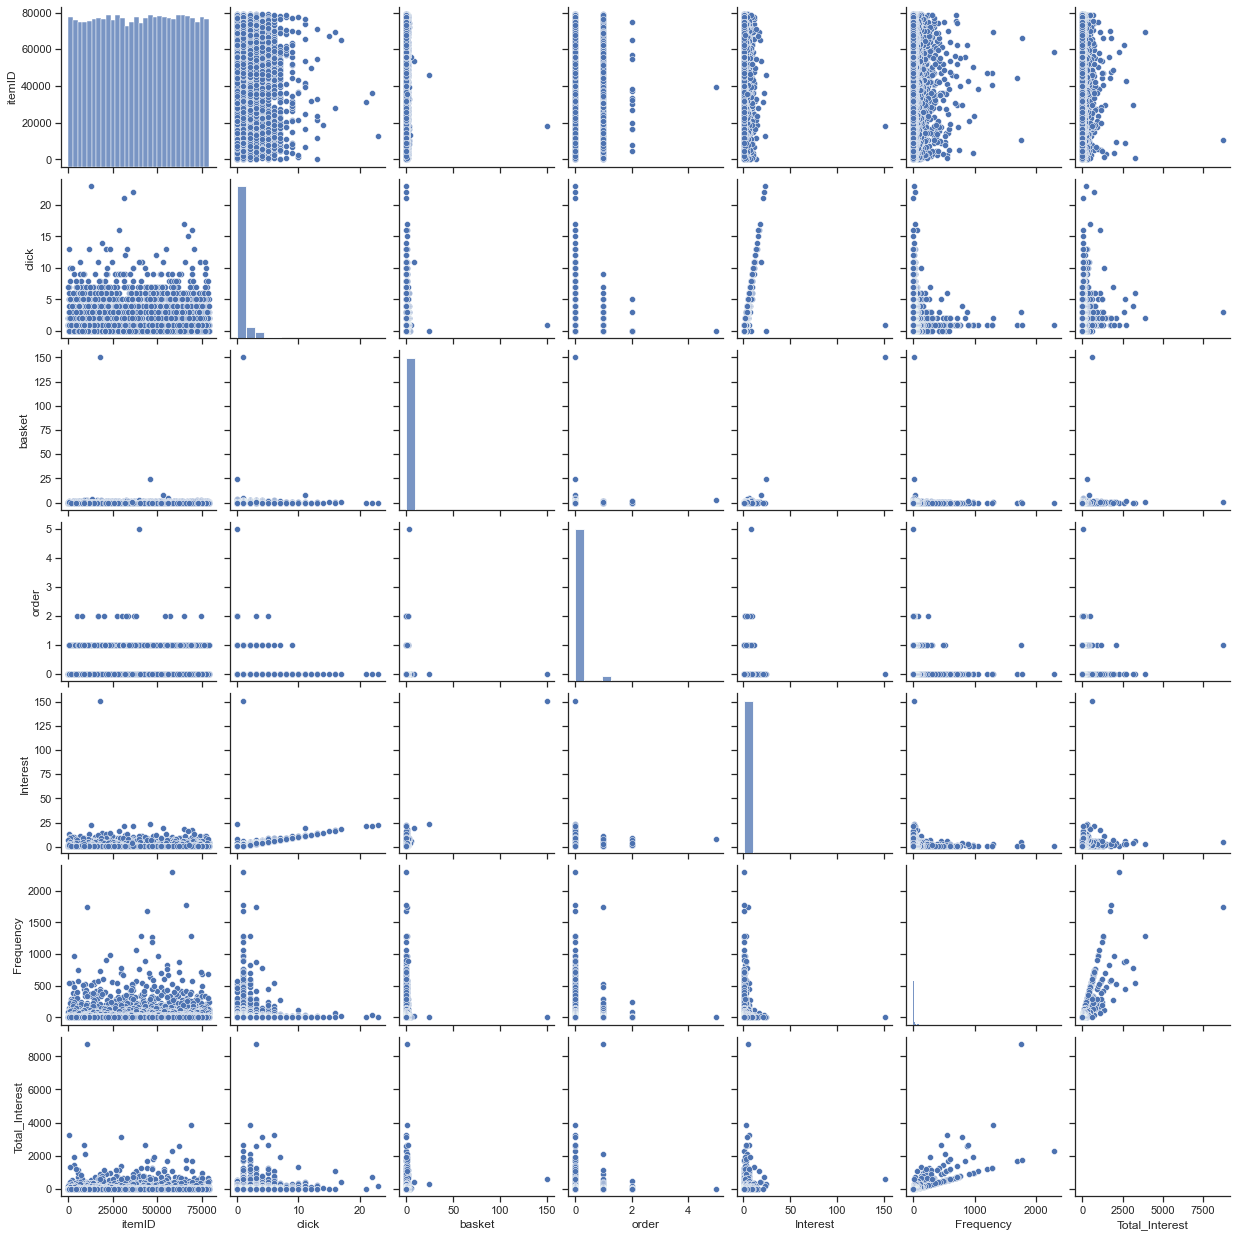

In [25]:
## Make pair plot using seaborn
import seaborn as sns

sns.set(style="ticks", color_codes=True)
g = sns.pairplot(book_data)


import matplotlib.pyplot as plt
plt.show()



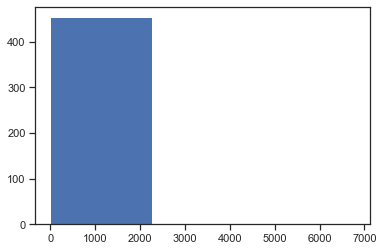

In [37]:
#Create histogram -> not suitable

x = book_data['Total_Interest'].value_counts()

plt.hist(x, bins = 3)
plt.show()